In [ ]:
#| hide
#| default_exp simple_gp_imputation

# Simple GP Imputation

> Imputation using a different Gaussian Processes for each variable

In [ ]:
#| hide
#| export
from gpfa_imputation.data_preparation import *
from gpfa_imputation.learner import NormParam
from gpfa_imputation.imputation import GPFAResult
import gpytorch
import torch
from torch import Tensor
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## GP

In [ ]:
#| export
class SimpleGP(gpytorch.models.ExactGP):
    "Exact GP implemnetation using GPyTorch"
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x, **params):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x, **params)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Learner

In [ ]:
#| export
class SimpleGPLearner():
    "Learner for a simple GP process. It handles only 1 dimensional time series"
    def __init__(self,
                 X: Tensor, # (n_obs) Univariate time series
                 T: Tensor = None, # (n_obs) Vector of time of observations.
                 # If none each observation are considered to be at the same distance
                ):
        self.prepare_X(X)
        if T is None: self.default_time(X)
        else: self.T = T
        self.T = self.T.to(X.device) # to support GPUs
        
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.model = SimpleGP(self.T, self.X, self.likelihood)
                
    def prepare_X(self, X):
        self.norm = Normalizer(X)
        self.X = self.norm.normalize(X)
        
    def default_time(self, X):
        self.T = torch.arange(X.shape[0])
        
    
    def train(self, n_iter=100, lr=0.1):
        # need to enable training mode
        self.model.train()
        self.likelihood.train()
        
        # Use the adam optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr) 
        
        # create new losses
        if not hasattr(self, 'losses'):
            self.losses = torch.zeros(n_iter)
            loss_offset = 0
        # append to previous losses
        else:
            loss_offset = self.losses.shape[0]
            self.losses = torch.concat([self.losses, torch.zeros(n_iter)])
            
        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
        for i in tqdm(range(n_iter)):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = self.model(self.T)
            # Calc loss and backprop gradients
            loss = -mll(output, self.X)
            self.losses[i + loss_offset] = loss.detach()
            loss.backward()
            self.printer(i)

            optimizer.step()
        
        
    def printer(self, i):
        pass
    
    @torch.no_grad() # don't calc gradients on predictions
    def predict_raw(self, T):
        self.model.eval()
        self.likelihood.eval()
        return self.likelihood(self.model(T))

    @torch.no_grad() # needed because raw output still has gradients attached
    def prediction_from_raw(self, raw_mean, raw_std):
        """ Takes a raw prediction and produces and final prediction, by reshaping and reversing normalization"""
        pred_mean = self.norm.reverse_normalize(raw_mean)
        pred_std = self.norm.reverse_normalize_std(raw_std)

        #remove pytorch gradients
        return NormParam(pred_mean.detach(), pred_std.detach())

    def predict(self, T):
        pred_raw = self.predict_raw(T)
        return self.prediction_from_raw(pred_raw.mean, pred_raw.stddev)

In [ ]:
X = torch.tensor([1.,2,3,4])

In [ ]:
l = SimpleGPLearner(X)

In [ ]:
l.train()

  0%|          | 0/100 [00:00<?, ?it/s]

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [ ]:
l.predict(torch.tensor([5, 7]))

NormalParameters(mean=tensor([5.5955, 6.4173]), std=tensor([0.1980, 0.6468]))

Imputation

The imputation using simple GPs make a separate GP process for each variable, which are completely independent

In [ ]:
#| export
class SimpleGPImputationExplorer:
    def __init__(
        self,
        data: pd.DataFrame , #observed data with missing data as NA
        cuda = False, # Use GPU?
    ):
        self.data = data
        
        device = 'cuda' if cuda else 'cpu'
        
        self.T = torch.arange(0, len(data), dtype=torch.float32, device=device) # time is encoded with a increase of 1
        
        # Training data
        self.train_idx = ~self.data.isna().any(axis=1)
        self.train_data = torch.tensor(self.data[self.train_idx].to_numpy().astype(np.float32), device=device)
        self.train_T = self.T[self.train_idx]
        
        self.learners = []
        
        for i in range(self.data.shape[1]):
            self.make_var_learner(i)
        
                       
        # if cuda: self.learner.cuda()
        
    def make_var_learner(self, i):
        # get only the ith column from the data
        x = self.train_data[:,i]
        learner = SimpleGPLearner(x, self.train_T)
        self.learners.append(learner)

        
    def fit(self):
        "Fit learners to training data"
        
        for learner in self.learners:
            learner.train()
            
        return self

    def predict(self):
        
        # return always tidy df
        
        preds = []
        
        for learner, feature_name in zip(self.learners, self.data.columns):
            pred = learner.predict(self.T)
            pred_mean = pd.DataFrame(pred.mean.cpu(), columns = ["mean"]).assign(time = self.T.cpu())
            pred_std = pd.DataFrame(pred.std.cpu(), columns = ["std"]).assign(time = self.T.cpu())
            
            pred = pd.merge(pred_mean, pred_std, on='time').assign(variable = feature_name)
            preds.append(pred)
                    
        
        return pd.concat(preds)
    
    def fit_predict(self):
        self.fit()
        return self.predict()
    
    def to_result(self, data_complete, units=None):
        # small hack set learner as None
        return GPFAResult(self.predict(), data_complete, learner=None, units=units)
    
    def __repr__(self):
        return f"""Simple GP Imputation Explorer:
    N obs: {self.data.shape[0]}
    N features {self.data.shape[1]} ({', '.join(self.data.columns)})
    N missing observations {self.data.isna().to_numpy().flatten().sum()}"""

    def __str__(self):
        return self.__repr__()

In [ ]:
fd = GPFADataTest.generate(2, 7).add_gap(3, ["x1"]).add_gap(2, ["x0"])

In [ ]:
gp_imp = SimpleGPImputationExplorer(fd.data)

In [ ]:
gp_imp

Simple GP Imputation Explorer:
    N obs: 7
    N features 2 (x0, x1)
    N missing observations 5

In [ ]:
gp_imp.fit()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Simple GP Imputation Explorer:
    N obs: 7
    N features 2 (x0, x1)
    N missing observations 5

In [ ]:
gp_imp.learners[0].predict(torch.tensor([3.]))

NormalParameters(mean=tensor([-0.1743]), std=tensor([0.1310]))

In [ ]:
gp_imp.data

,x0,x1
0,0.036745,0.001946
1,-0.315458,-0.072469
2,-0.178399,-0.108125
3,NaN,NaN
4,NaN,NaN
5,0.415067,NaN
6,-0.239938,-0.531049


In [ ]:
gp_imp.train_data

tensor([[ 0.0367,  0.0019],
        [-0.3155, -0.0725],
        [-0.1784, -0.1081],
        [-0.2399, -0.5310]])

In [ ]:
gp_imp.predict()

,mean,time,std,variable
0,-0.082341,0.0,0.117911,x0
1,-0.235815,1.0,0.117911,x0
2,-0.176091,2.0,0.117911,x0
3,-0.174308,3.0,0.131003,x0
4,-0.174308,4.0,0.131003,x0
5,-0.174308,5.0,0.131003,x0
6,-0.202907,6.0,0.117911,x0
0,-0.006813,0.0,0.033960,x1
1,-0.052788,1.0,0.029690,x1
2,-0.124542,2.0,0.032953,x1


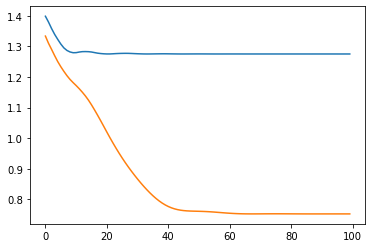

In [ ]:
#| hide
def plot_losses(self: SimpleGPImputationExplorer):
    for l in self.learners:
        plt.plot(l.losses)

plot_losses(gp_imp)

In [ ]:
fd.data_compl_tidy

,time,variable,value,is_missing
0,0.0,x0,0.036745,False
1,1.0,x0,-0.315458,False
2,2.0,x0,-0.178399,False
3,3.0,x0,-0.074237,True
4,4.0,x0,-0.081575,True
5,5.0,x0,0.415067,False
6,6.0,x0,-0.239938,False
7,0.0,x1,0.001946,False
8,1.0,x1,-0.072469,False
9,2.0,x1,-0.108125,False


In [ ]:
gp_imp.to_result(fd.data_compl_tidy).display_results()

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

variable,r2
x0,-690.2857
x1,-1.9200


In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()